In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_163.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_308.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_086.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_123.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_236.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_214.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_060.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_156.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_154.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_168.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_153.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_225.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_032.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_139.npy
/kaggle/input/mri-data/Data/Train/masks_reformatted/mask_120.npy
/kaggle/input/mri-data/Da

In [12]:
import tensorflow as tf
from keras.layers import Conv3D, ConvLSTM3D, Reshape, Conv3DTranspose, UpSampling3D, MaxPooling3D, Concatenate, Input
from keras.layers import Bidirectional, BatchNormalization, Dropout, Dense, Flatten, Attention, Add, Activation
from keras.models import Model
import keras
import matplotlib.pyplot as plt
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,Adadelta
from glob import glob


In [13]:
#Get corresponsing Mask id
def get_id(path):
    slice = path.split(".")[2]
    id = slice[len(slice)-1:len(slice)-4:-1]

    return id[-1::-1]

In [14]:
#Load all helper functions onto notebook
#Image generator
def generate_image(paths):
    for img_path in paths:
        example_id = get_id(img_path)
        sample = np.load(img_path)

        mask = np.load("../input/mri-data/Data/Train/masks_reformatted/mask_"+example_id+".npy","r")
        # reshape mask
        # mask_reshaped=np.reshape(mask,(128*128*128,4))
        # Normalization
        normalized_sample = (sample-np.mean(sample, axis=0))/np.std(sample, axis=0)
        #normalized_sample=np.round(normalized_sample,3)
        yield normalized_sample, mask


In [15]:
#Batch generator

def batch_generator(paths, batch_size):
    while True:
        image = generate_image(paths)

        img_batch = list()
        mask_batch = list()

        for sample, mask in image:
            img_batch.append(sample)
            mask_batch.append(mask)

            if (len(img_batch) == batch_size):
                yield np.stack(img_batch, axis=0), np.stack(mask_batch, axis=0)
                img_batch = []
                mask_batch = []

        if (len(img_batch) != 0):
            yield np.stack(img_batch, axis=0), np.stack(mask_batch, axis=0)
            img_batch = []
            mask_batch = []

In [16]:
#Metrics 
from keras.losses import categorical_crossentropy
def dice_coef(y_true, y_pred):
    ytrue_f = keras.backend.flatten(y_true)
    ypred_f = keras.backend.flatten(y_pred)

    intersection = keras.backend.sum(
        ytrue_f*ypred_f)

    E = keras.backend.epsilon()
    dice = (2.*intersection+E)/(keras.backend.sum(ytrue_f)+keras.backend.sum(ypred_f)+E)
    return dice


def dice_loss(y_true, y_pred):
    dice_loss = 1-dice_coef(y_true, y_pred)
    return dice_loss


def overall_loss(y_true, y_pred):
    loss = (0.5*categorical_crossentropy(y_true, y_pred)) + \
        dice_loss(y_true, y_pred)
    return loss

def multilabel_loss(y_true,y_pred,m):
    dice=0
    for i in range(m):
        dice+=dice_coef(y_true[:,:,:,i],y_pred[:,:,:,i])
    return dice


In [17]:
#Learning rate scheduler
def scheduler(epoch,lr):
    if(epoch%5==0):
        return lr*tf.math.exp(-0.1*epoch)
    else:
        return lr

In [18]:
#2 path CNN model
def create_2pathed_shallow():
    input_layer = Input((128, 128, 128, 3))
    # first encoding block
    # Convolution layers
    conv1_e_1 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(input_layer)
    conv1_e_2 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv1_e_1)
    conv1_e_3 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv1_e_2)

    # Downsample
    pool1_e_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(conv1_e_3)

    # Convolution Layers
    conv1_e_4 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(pool1_e_1)
    conv1_e_5 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv1_e_4)
    conv1_e_6 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), strides=1, activation='elu', use_bias=True, bias_initializer='he_normal')(conv1_e_5)

    # Batch normalization to get mean 0 activations
    batch1 = BatchNormalization()(conv1_e_6)

    # Second encoding block
    # Convolutions
    conv2_e_1 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(input_layer)
    conv2_e_2 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv2_e_1)
    conv2_e_3 = Conv3D(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv2_e_2)

    # Pooling
    pool2_e_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(conv2_e_3)

    # Convolutions
    conv2_e_4 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(pool2_e_1)
    conv2_e_5 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv2_e_4)
    conv2_e_6 = Conv3D(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv2_e_5)

    batch2 = BatchNormalization()(conv2_e_6)

    # Concatenate
    path_combined = Concatenate(axis=4)([batch1, batch2])

    # Combined convolutions
    conv_7 = Conv3D(filters=32, kernel_initializer='he_normal', kernel_size=(3, 3, 3), activation='elu',
                    strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(path_combined)
    conv_8 = Conv3D(filters=64, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv_7)
    conv_9 = Conv3D(filters=128, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(conv_8)

    batch3 = BatchNormalization()(conv_9)

    # Deconvolution
    d_conv = Conv3DTranspose(filters=128, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, use_bias=True, bias_initializer='he_normal')(batch3)
    d_conv_1 = Conv3DTranspose(filters=64, kernel_initializer='he_normal', activation='elu',
                               strides=1, kernel_size=(3, 3, 3), padding='valid', use_bias=True, bias_initializer='he_normal')(d_conv)
    d_conv_2 = Conv3DTranspose(filters=32, kernel_initializer='he_normal', activation='elu',
                               strides=1, kernel_size=(3, 3, 3), padding='valid', use_bias=True, bias_initializer='he_normal')(d_conv_1)

    # first decoding block
    dconv1_e_1 = Conv3DTranspose(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(d_conv_2)
    dconv1_e_2 = Conv3DTranspose(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(dconv1_e_1)
    dconv1_e_3 = Conv3DTranspose(filters=16, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(dconv1_e_2)

    upsample_e_1 = UpSampling3D(size=(2, 2, 2))(dconv1_e_3)

    dconv1_e_4 = Conv3DTranspose(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(upsample_e_1)
    dconv1_e_5 = Conv3DTranspose(filters=8, kernel_initializer='he_normal', kernel_size=(
        3, 3, 3), activation='elu', strides=1, padding='valid', use_bias=True, bias_initializer='he_normal')(dconv1_e_4)

    batchnorm = BatchNormalization()(dconv1_e_5)

    mask = Conv3DTranspose(filters=4, kernel_initializer='glorot_normal', kernel_size=(
        3, 3, 3), activation='softmax', strides=1, padding='valid', use_bias=True, bias_initializer='glorot_normal')(batchnorm)

    model = Model(inputs=input_layer, outputs=mask)
    return model


In [19]:
#Compute steps per epoch
def steps(m,batchsize):
    return (m+batchsize-1)//batchsize

In [20]:
#Main program
sample_paths=sorted(glob("../input/mri-data/Data/Train/samples_processed/*.npy"))
masks_paths=sorted(glob("../input/mri-data/Data/Train/masks_reformatted/*.npy"))


In [21]:
#Train-test split
train_sample_paths,test_sample_paths=train_test_split(sample_paths,test_size=0.25)

In [22]:
len(train_sample_paths)

276

In [23]:
traingen=batch_generator(train_sample_paths,8)
testgen=batch_generator(test_sample_paths,8)

In [22]:
sample,masks=next(testgen)

In [23]:
sample.shape,masks.shape

((8, 128, 128, 128, 3), (8, 128, 128, 128, 4))

In [24]:
model=create_2pathed_shallow()


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 126, 126, 12  656         ['input_1[0][0]']                
                                6, 8)                                                             
                                                                                                  
 conv3d_6 (Conv3D)              (None, 126, 126, 12  656         ['input_1[0][0]']                
                                6, 8)                                                         

In [26]:
train_steps=steps(len(train_sample_paths),8)
test_steps=steps(len(test_sample_paths),8)

In [27]:
import datetime

opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=dice_loss,metrics=[dice_coef,categorical_crossentropy,overall_loss,tf.keras.metrics.CategoricalAccuracy()])

#callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
schedule=tf.keras.callbacks.LearningRateScheduler(scheduler)
plateau_handler=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1)
nanterminate=tf.keras.callbacks.TerminateOnNaN()
#earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_loss')
checkpoints=tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoints/2pathed_shallow/",save_weights_only=False,save_freq='epoch',save_best_only=True,monitor='dice_coef',mode='max',verbose=1)

In [28]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
tf.test.is_gpu_available()

True

In [30]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))


In [36]:
#session.close()

In [31]:
history=model.fit(traingen,steps_per_epoch=train_steps,epochs=30,validation_data=testgen,validation_steps=test_steps,verbose=1,callbacks=[tensorboard_callback,plateau_handler,schedule,checkpoints,nanterminate])

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.6612 - dice_coef: 0.3402 - categorical_crossentropy: 1.8570 - overall_loss: 1.5897 - categorical_accuracy: 0.4438
Epoch 1: dice_coef improved from -inf to 0.34022, saving model to model_checkpoints/2pathed_shallow/
35/35 [==============================] - 417s 11s/step - loss: 0.6612 - dice_coef: 0.3402 - categorical_crossentropy: 1.8570 - overall_loss: 1.5897 - categorical_accuracy: 0.4438 - val_loss: 0.5029 - val_dice_coef: 0.4972 - val_categorical_crossentropy: 3.1857 - val_overall_loss: 2.0958 - val_categorical_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.4879 - dice_coef: 0.5129 - categorical_crossentropy: 2.0824 - overall_loss: 1.5291 - categorical_accuracy: 0.6572
Epoch 2: dice_coef improved from 0.34022 to 0.51294, saving model to model_checkpoints/2pathed_shallow/
35/35 [==============================] - 388s 11s/step - loss: 0.4879 - dice_coef: 0.51

Text(0, 0.5, 'Loss')

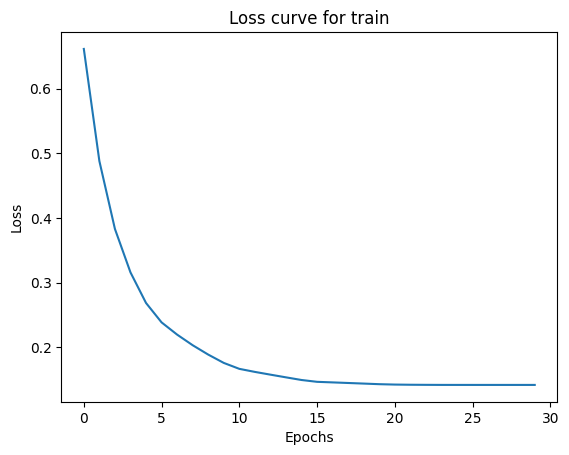

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("Loss curve for train")
plt.xlabel("Epochs")
plt.ylabel("Loss")


Text(0, 0.5, 'Loss')

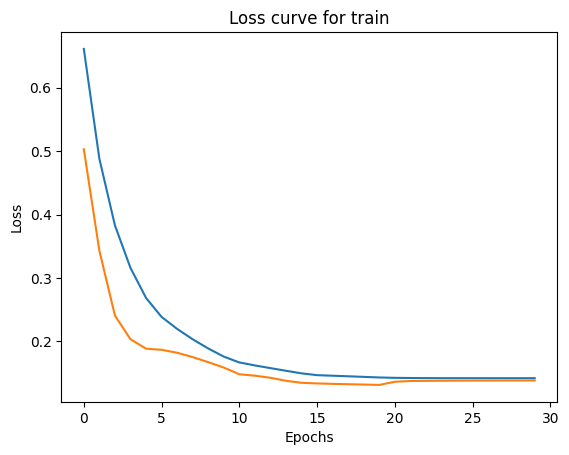

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss curve for train")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Dice score')

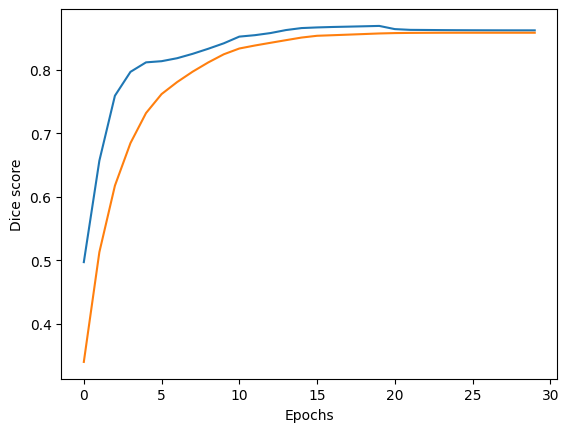

In [36]:
plt.plot(history.history['val_dice_coef'])
plt.plot(history.history['dice_coef'])
plt.xlabel("Epochs")
plt.ylabel("Dice score")

Text(0, 0.5, 'Accuracy')

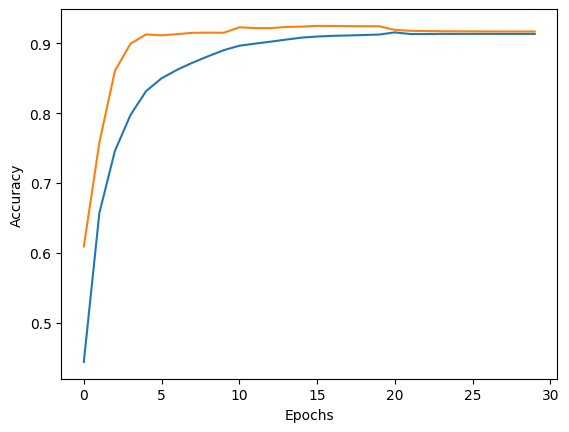

In [37]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 1.0, 'Weighted categorical and dice loss')

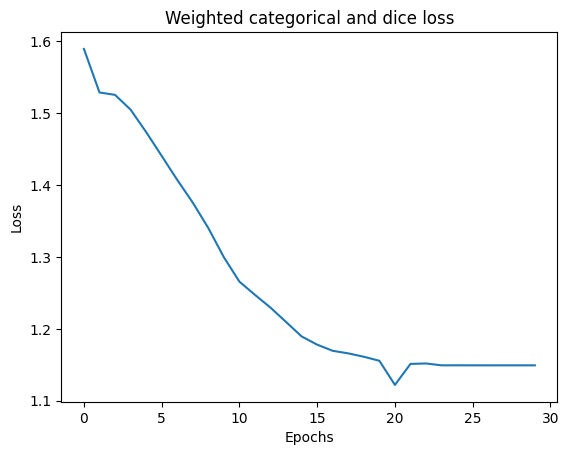

In [40]:
plt.plot(history.history['overall_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Weighted categorical and dice loss")